[View in Colaboratory](https://colab.research.google.com/github/Ananthakumar-Sethuramanujam/Machine-Learning/blob/master/Campaign%20Conversion/Campaign_Conversion.ipynb)

# About the Notebook 

This Notebook deals with predicting whether a customer contacted over phone by a bank will subscribe to term deposit or not.


https://archive.ics.uci.edu/ml/datasets/Bank+Marketing is the link to the dataset

# Install Spark on Colab

In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.2.1/spark-2.2.1-bin-hadoop2.7.tgz
!tar xf spark-2.2.1-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu artful-security InRelease [83.2 kB]
Hit:2 http://archive.ubuntu.com/ubuntu artful InRelease
Get:3 http://archive.ubuntu.com/ubuntu artful-updates InRelease [88.7 kB]
Get:4 http://security.ubuntu.com/ubuntu artful-security/main amd64 Packages [237 kB]
Get:5 http://archive.ubuntu.com/ubuntu artful-backports InRelease [74.6 kB]
Get:6 http://archive.ubuntu.com/ubuntu artful-updates/universe Sources [45.1 kB]
Get:7 http://archive.ubuntu.com/ubuntu artful-updates/universe amd64 Packages [149 kB]
Get:8 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 Packages [364 kB]
Fetched 1,041 kB in 1s (864 kB/s)
Reading package lists... Done


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Read the data and create a spark dataframe

Important point to note here is that spark will parallelize as long as we use either RDD or spark DataFrame. Using Pandas dataFrame will be single threaded. We cannot use Dataset API since it is supported only in Java and Scala.

We will use spark dataframe instead of RDD. This is because RDD does not take advantage of catalyst optimization Spark provides.

In [55]:
from google.colab import files
datafile=files.upload()

Saving bank-additional.zip to bank-additional.zip


In [6]:
import zipfile
zfile = zipfile.ZipFile('bank-additional.zip')
for finfo in zfile.infolist():
  print(finfo.filename)

bank-additional/
bank-additional/.DS_Store
__MACOSX/
__MACOSX/bank-additional/
__MACOSX/bank-additional/._.DS_Store
bank-additional/.Rhistory
bank-additional/bank-additional-full.csv
bank-additional/bank-additional-names.txt
bank-additional/bank-additional.csv
__MACOSX/._bank-additional


In [7]:
zip_read=zfile.open('bank-additional/bank-additional-full.csv')   #Open the csv file

In [8]:
import numpy as np
import pandas as pd
data=pd.read_csv(zip_read,header='infer',sep=';')     # read the data with pandas

In [9]:

data=pd.DataFrame(data) # create pandas dataframe

In [10]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [11]:
df=spark.createDataFrame(data)   # Spark DataFrame is created

In [12]:
df.show()

+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|  housemaid| married|           basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57|   services| married|        high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.

In [13]:
df.printSchema()

root
 |-- age: long (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- pdays: long (nullable = true)
 |-- previous: long (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



In [14]:
df.columns  # we can use .columns similar to pandas dataframe also

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

# Feature Information

   **Attribute Information:**
   
   1 - age
   
   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   
   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   
   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   
   5 - default: has credit in default? (categorical: "no","yes","unknown")
   
   6 - housing: has housing loan? (categorical: "no","yes","unknown")
   
   7 - loan: has personal loan? (categorical: "no","yes","unknown")
  
  *Related with the last contact of the current campaign:*
  
   8 - contact: contact communication type (categorical: "cellular","telephone") 
   
   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   
  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  
  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
  
    *other attributes:*
    
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  
  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  
  14 - previous: number of contacts performed before this campaign and for this client (numeric)
  
  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
  
  * social and economic context attributes*
   
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  
  17 - cons.price.idx: consumer price index - monthly indicator (numeric)    
  
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)  
  
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  
  20 - nr.employed: number of employees - quarterly indicator (numeric)

 * Output variable (desired target):*
 
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [15]:
# Rename the spark dataframe columns

df=df.toDF('age','job','marital','education','default','housing','loan','contact','month','day_of_week','duration','campaign','days since client last contacted'
 ,'previous contacts with client','previous campaign outcome','employment variation rate','consumer price index','consumer confidence index'
,'euribor 3 month rate','number of employees','target')

# Pipelining feature transformation

In [16]:
df.select('*').count()    #count the number of rows

41188

In [17]:
df.describe().show() 
# Summary statistics for predictors are shown here. For categorical predictors mean and stddev will be null

+-------+-----------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+-----------------+------------------+--------------------------------+-----------------------------+-------------------------+-------------------------+--------------------+-------------------------+--------------------+-------------------+------+
|summary|              age|    job| marital|education|default|housing| loan|  contact|month|day_of_week|         duration|          campaign|days since client last contacted|previous contacts with client|previous campaign outcome|employment variation rate|consumer price index|consumer confidence index|euribor 3 month rate|number of employees|target|
+-------+-----------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+-----------------+------------------+--------------------------------+-----------------------------+-------------------------+-------------------------+--------------------+-------------------

In [18]:
missing_value_dropped_data = df.na.drop()   # drop the missing values

In [19]:
missing_value_dropped_data.select('*').count()  
# There are no missing values because the count before dropping na and after dropping na is same

41188

In [20]:
 """ Note that we created this spark dataframe df from pandas dataframe data. 
We can convert back the spark dataframe df to pandas dataframe. 
This is just an illustration                                                  """
  
back_converted= df.toPandas()
back_converted.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,days since client last contacted,previous contacts with client,previous campaign outcome,employment variation rate,consumer price index,consumer confidence index,euribor 3 month rate,number of employees,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [21]:
sc.version            # with the sparkcontext instance we can check spark version
# Use the corresponfing documentation to Transfrom the features

'2.2.1'

In [22]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [23]:
# Select the categorical columns
categorical_cols=[]
list1=df.dtypes
for i,j in list1:
    if j=='string':
      categorical_cols.append(i)
categorical_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'previous campaign outcome',
 'target']

In [24]:
# remove target as we have to label encode it
#remove day and month columns as they are not really useful in building the model
categorical_cols.remove('target')
categorical_cols.remove('day_of_week')
categorical_cols.remove('month')
categorical_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'previous campaign outcome']

In [25]:
categoricalColumns = categorical_cols
categoricalColumns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'previous campaign outcome']

In [26]:

stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "classVec")
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [27]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="target", outputCol="label")   # Now we StringIndex the target variable
stages += [label_stringIdx]

In [28]:
import copy
categorical_cols1=copy.deepcopy(categorical_cols)
categorical_cols1.append('target')                   # deep copy is done to avoid clash between already referenced lists
categorical_cols1.append('day_of_week')
categorical_cols1.append('month')

In [29]:
#select only the numeric columns
numericColumns=[]
for i in df.columns:
  if i not in categorical_cols1:
    numericColumns.append(i)
numericColumns

['age',
 'duration',
 'campaign',
 'days since client last contacted',
 'previous contacts with client',
 'employment variation rate',
 'consumer price index',
 'consumer confidence index',
 'euribor 3 month rate',
 'number of employees']

In [30]:
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericColumns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [31]:
categoricalColumns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'previous campaign outcome']

In [32]:
stages     # Print the stages

[StringIndexer_4ddc83d05c2d46a6b783,
 OneHotEncoder_461ebda8aebd7d8f47e0,
 StringIndexer_4a3f9ef3110e746c9792,
 OneHotEncoder_464d8df2c00ba7896454,
 StringIndexer_40e898be7505008b21fb,
 OneHotEncoder_4373b04a1ca3d81bca59,
 StringIndexer_4b5f93ee95828a9ed533,
 OneHotEncoder_45daac5128b21b1ca502,
 StringIndexer_4c6590aacfa9734c7507,
 OneHotEncoder_4346bae6e8b0103ea0f7,
 StringIndexer_4715882912ef301b872e,
 OneHotEncoder_4f1282a8eac6030bbc7e,
 StringIndexer_4592bae1b53f528fe92a,
 OneHotEncoder_4fecba70b45463e58bd8,
 StringIndexer_49acac15db04a34785f9,
 OneHotEncoder_4a769b33259c76d82c28,
 StringIndexer_4245b7d11ae87d801814,
 VectorAssembler_4ca58faa53bf97c2c4a9]

In [33]:
# Build a pipeline of stages
cols= df.columns
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()   # Note label and feature vector is added to the schema

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: long (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- days since client last contacted: long (nullable = true)
 |-- previous contacts with client: long (nullable = true)
 |-- previous campaign outcome: string (nullable = true)
 |-- employment variation rate: double (nullable = true)
 |-- consumer price index: double (nullable = true)
 |-- consumer confidence index: double (nullable = true)
 |-- euribor 3 month rate: double (nullable = true)
 |-- number of employees: double (nullable = true)
 |-- target: s

# Train - Test split

In [34]:
df.take(5)


[Row(label=0.0, features=SparseVector(40, {8: 1.0, 11: 1.0, 18: 1.0, 21: 1.0, 24: 1.0, 25: 1.0, 28: 1.0, 30: 56.0, 31: 261.0, 32: 1.0, 33: 999.0, 35: 1.1, 36: 93.994, 37: -36.4, 38: 4.857, 39: 5191.0}), age=56, job='housemaid', marital='married', education='basic.4y', default='no', housing='no', loan='no', contact='telephone', month='may', day_of_week='mon', duration=261, campaign=1, days since client last contacted=999, previous contacts with client=0, previous campaign outcome='nonexistent', employment variation rate=1.1, consumer price index=93.994, consumer confidence index=-36.4, euribor 3 month rate=4.857, number of employees=5191.0, target='no'),
 Row(label=0.0, features=SparseVector(40, {3: 1.0, 11: 1.0, 15: 1.0, 22: 1.0, 24: 1.0, 25: 1.0, 28: 1.0, 30: 57.0, 31: 149.0, 32: 1.0, 33: 999.0, 35: 1.1, 36: 93.994, 37: -36.4, 38: 4.857, 39: 5191.0}), age=57, job='services', marital='married', education='high.school', default='unknown', housing='no', loan='no', contact='telephone', mo

In [35]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 28846
Test Dataset Count: 12342


# Logistic Regression

In [36]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

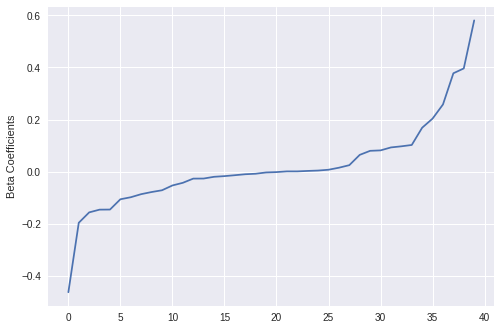

In [37]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

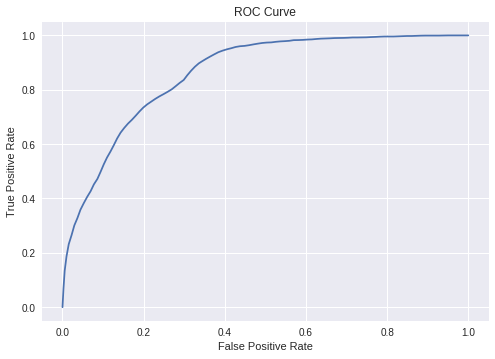

Training set areaUnderROC: 0.8607506745153637


In [38]:
# Area under ROC
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [39]:
#Predict on the test set
predictions = lrModel.transform(test)
#predictions.show()
predictions.select('features', 'label', 'prediction', 'probability').show(10)

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.95933240275166...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.93270033108336...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.96003852992076...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.96407459433495...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.95751736235494...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.96599081568245...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.94984105061678...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.96312651555094...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.96143070196250...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.95404860077699...|
+--------------------+-----+----------+--------------------+
only showing top 10 rows



In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8667326209035489


# Decision Tree Classifier

In [41]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('features', 'label', 'prediction', 'probability').show(10)

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.98235792246894...|
|(40,[0,11,14,21,2...|  0.0|       0.0|         [0.64,0.36]|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.98235792246894...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.98235792246894...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.98235792246894...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.98235792246894...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.98235792246894...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.98235792246894...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.98235792246894...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.98235792246894...|
+--------------------+-----+----------+--------------------+
only showing top 10 rows



In [42]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7552579457359191


# Random Forest Classifier

In [43]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('features', 'label', 'prediction', 'probability').show(10)

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.97059414847515...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.72350267467540...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.97059414847515...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.97148549315432...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.97148549315432...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.97148549315432...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.97059414847515...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.97059414847515...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.97148549315432...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.97059414847515...|
+--------------------+-----+----------+--------------------+
only showing top 10 rows



In [44]:
predictions.select('features', 'label', 'prediction', 'probability').toPandas().head(n=20)

,features,label,prediction,probability
0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.97059414847515, 0.02940585152485]"
1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.7235026746754061, 0.2764973253245938]"
2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.97059414847515, 0.02940585152485]"
3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.9714854931543224, 0.028514506845677596]"
4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.9714854931543224, 0.028514506845677596]"
5,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.9714854931543224, 0.028514506845677596]"
6,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.97059414847515, 0.02940585152485]"
7,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.97059414847515, 0.02940585152485]"
8,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.9714854931543224, 0.028514506845677596]"
9,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.97059414847515, 0.02940585152485]"


In [45]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9266320351555145


# Gradient Boosted Tree Classifier

In [46]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('features', 'label', 'prediction', 'probability').show(10)

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.93222619571571...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.62508587530678...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.93238387095846...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.93238387095846...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.93169052409295...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.93238387095846...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.91965084799854...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.93238387095846...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.93222619571571...|
|(40,[0,11,14,21,2...|  0.0|       0.0|[0.93169052409295...|
+--------------------+-----+----------+--------------------+
only showing top 10 rows



In [47]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9459097299552714


# Intermediate Observation

Gradient Boosted Tree Classifier gave the best result with area under ROC at 0.94. We will tune this model

# Parameter tuning - GBT classifier

In [48]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. (default: 10)
featuresCol: features column name. (default: features)
labelCol: label column name. (default: label)
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic (default: logistic)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5)
ma

In [0]:
""" This is the code to tune the parameters. I am using Google Colab and it offers a single node cluster.
    Hence the code will take a long time to execute. So, if you have a multi node cluster either in AWS EMR or Databricks,
    you can try this out. 
""" 

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)   # Runs cross validation on training data
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)